# Introduction
In the following you will see how to read the provided files for the mini-project 3.
First you will see how to read each of the provided files. Then, you will see a more elegant way of using this data for training neural networks.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive' )

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd '/content/gdrive/My Drive/ECSE_551_F_2020/Mini_Project_03/'
#!ls './data/'

/content/gdrive/.shortcut-targets-by-id/1aFbNqiPAnLUOI8W45LtUsSHyvKg1-Lck/ECSE_551_F_2020/Mini_Project_03


In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch

In [4]:
from sklearn.preprocessing import LabelEncoder

(60000, 64, 128) (60000, 1)


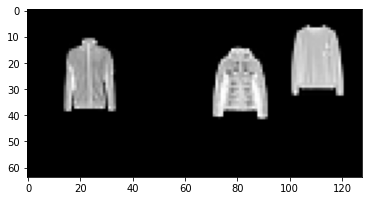

In [5]:
# Read a pickle file and disply its samples
# Note that image data are stored as unit8 so each element is an integer value between 0 and 255
data = pickle.load(open('./Train.pkl', 'rb'), encoding='bytes')
targets = np.genfromtxt('./TrainLabels.csv', delimiter=',', skip_header=1)[:,1:]
plt.imshow(data[1234,:,:],cmap='gray', vmin=0, vmax=256)
print(data.shape, targets.shape)

# Dataset class
*Dataset* class and the *Dataloader* class in pytorch help us to feed our own training data into the network. Dataset class is used to provide an interface for accessing all the training or testing samples in your dataset. For your convinance, we provide you with a custom Dataset that reads the provided data including images (.pkl file) and labels (.csv file).

# Dataloader class
Although we can access all the training data using the Dataset class, for neural networks, we would need batching, shuffling, multiprocess data loading, etc. DataLoader class helps us to do this. The DataLoader class accepts a dataset and other parameters such as batch_size.

In [6]:
# Transforms are common image transformations. They can be chained together using Compose.
# Here we normalize images img=(img-0.5)/0.5
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
# img_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([0.1307], [0.3081])
# ])

In [7]:
# img_file: the pickle file containing the images
# label_file: the .csv file containing the labels
# transform: We use it for normalizing images (see above)
# idx: This is a binary vector that is useful for creating training and validation set.
# It return only samples where idx is True

class MyDataset(Dataset):
    def __init__(self, img_file, label_file, transform=None, idx=None):
        self.data = pickle.load(open(img_file, 'rb'), encoding='bytes')
        self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1)[:,1:]
        if idx is not None:
            self.targets = self.targets[idx]
            self.data = self.data[idx]
        self.transform = transform

        self.targets = self.targets.reshape(-1)
        self.targets = self.targets - 5

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.astype('uint8'), mode='L')

        if self.transform is not None:
           img = self.transform(img)

        return img, target

In [8]:
# Read image data and their label into a Dataset class
dataset = MyDataset('./Train.pkl', './TrainLabels.csv', transform=img_transform, idx=None)

In [9]:
batch_size = 256 #feel free to change it
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

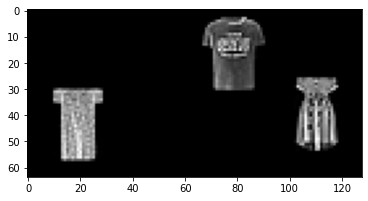

In [10]:
# Read a batch of data and their labels and display them
# Note that since data are transformed, they are between [-1,1]
imgs, labels = (next(iter(dataloader)))
imgs = np.squeeze(imgs)
plt.imshow(imgs[5].cpu().numpy(),cmap='gray', vmin=-1, vmax=1) #.transpose()

# CNN

In [11]:
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

# cnn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 6 * 14, 1344)
        self.fc2 = nn.Linear(1344, 9)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 6 * 14)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [12]:
train_index = np.arange(50000)
test_index = np.arange(50000, 60000)
batch_size = 32 #feel free to change it

# Read image data and their label into a Dataset class
train_set = MyDataset('./Train.pkl', './TrainLabels.csv', transform=img_transform, idx=train_index)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_set = MyDataset('./Train.pkl', './TrainLabels.csv', transform=img_transform, idx=test_index)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [13]:
net = Net()
# if there is a available cuda device, use GPU, else, use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# set criterion to cross entropy loss
criterion = nn.CrossEntropyLoss()

# set learning rate to 0.001
optimizer = optim.SGD(net.parameters(), lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)

In [14]:
def train(num_epochs=2): # Feel free to change it
    net.train()

    # Here is a piece of code that reads data in batch.
    # In each epoch all samples are read in batches using dataloader
    for epoch in range(num_epochs):
        for data in train_loader:
            img, label = data

            img = img.to(device)
            label = label.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(img)

            loss = criterion(outputs, label)
            # loss = F.nll_loss(outputs, label)
            loss.backward()
            optimizer.step()

    print('Finished Training')

In [15]:
def test():
    net.eval()

    correct = 0
    total = 0

    # calculate accuracy
    with torch.no_grad():
        for data in test_loader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            # get the index of the max output
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network: %d %%' % (
        100 * correct / total))

In [16]:
epoch = 5
train(epoch)

Finished Training


In [17]:
test()

Accuracy of the network: 11 %
